In [46]:
import json
import pandas as pd
import numpy as np  
import os
import random

from metric import r_precision, dcg_at_k, ndcg_at_k
from utils import generate_playlists, generate_testcases

from numpy import linalg as LA

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import collections

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [47]:
path_to_data = '../../data' #'/content/drive/MyDrive/DO_AN_KHDL/DATA'
path_audio_feats = os.path.join(path_to_data, 'audio_features.tsv')
path_playlists = os.path.join(path_to_data, 'playlists.tsv')
path_tracks = os.path.join(path_to_data, 'tracks.tsv')

In [48]:
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_playlists = pd_playlists.fillna('None')

In [49]:
pd_tracks = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_tracks, pd_playlists, left_on = 'playlist_id', right_on = 'playlist_id')

pd_tracks = pd_tracks.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [50]:
pd_full.shape

(86400, 27)

In [51]:
#Thông tin rỗng là discription, ta có thể chỉ điền vào "None"
pd_full = pd_full.fillna('None')

In [52]:
#Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()

In [53]:
pd_full.shape

(86350, 27)

In [54]:
pd_full['available_markets'] = pd_full['available_markets'].apply(lambda x : x[1:-1].split(', '))
pd_full['count_available_markets'] = pd_full['available_markets'].apply(lambda x : len(x))

In [55]:
pd_full.head()

,track_id,track_name,playlist_id,playlist_name_x,artist_ids,artist_names,album_id,album_name,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,time_signature,available_markets,popularity,description,num_tracks,num_followers,count_available_markets
0,463CkQjx2Zk1yXoBuierM9,Levitating (feat. DaBaby),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['6M2wZ9GZgrQXHCFfjv46we', '4r63FhuTkUYltbVAg5...","['Dua Lipa', 'DaBaby']",04m06KhJUuwe1Q487puIud,Levitating (feat. DaBaby),203064,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.00000,0.0674,0.915,102.977,https://api.spotify.com/v1/audio-analysis/463C...,4,"['AD', 'AE', 'AL', 'AR', 'AU', 'BA', 'BE', 'BG...",90,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,88
1,7igeByaBM0MgGsgXtNxDJ7,positions,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],3jqEvfiu2ENgmgzZq27zbi,positions,172324,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.00000,0.0940,0.675,144.005,https://api.spotify.com/v1/audio-analysis/7ige...,4,[],76,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,1
2,0lx2cLdOt3piJbcaXIV74f,willow,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['06HL4z0CvFAxyc27GXpf02'],['Taylor Swift'],2Xoteh7uEpea4TohMxjtaq,evermore,214706,0.392,0.574,7,-9.195,1,0.1700,0.83300,0.00179,0.1450,0.529,81.112,https://api.spotify.com/v1/audio-analysis/0lx2...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",91,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,91
3,2Z8yfpFX0ZMavHkcIeHiO1,Monster (Shawn Mendes & Justin Bieber),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['7n2wHs1TKAczGzO7Dd2rGr', '1uNFoZAHBGtllmzznp...","['Shawn Mendes', 'Justin Bieber']",3yVVL2EYLp8g7gT08VvYKy,Monster,178994,0.652,0.383,2,-7.076,0,0.0516,0.06760,0.00000,0.0828,0.549,145.765,https://api.spotify.com/v1/audio-analysis/2Z8y...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",93,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,91
4,6zFMeegAMYQo0mt8rXtrli,HOLIDAY,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['7jVv8c5Fj3E9VhNjxT4snq'],['Lil Nas X'],4EvukZrmNBiqJbs3LwOSHu,HOLIDAY,154997,0.810,0.511,5,-6.924,0,0.1640,0.12000,0.00000,0.0832,0.837,151.947,https://api.spotify.com/v1/audio-analysis/6zFM...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",93,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,92


## k-means

* **Thuộc tính**: lấy toàn bộ các thuộc tính số (numeric features) của các track làm đặc trưng.
* **Mô tả ý tưởng**:
    * Phân cụm tất cả các bài hát thành **k** cụm sử dụng thuật toán K-means clustering, chọn giá trị **k** sử dụng phương pháp khuỷu tay (*elbow method*).
    * Với tập hợp các seed tracks, ta chọn 1 cluster chứa nhiều seed tracks nhất. Sau khi chọn được cluster, ta sẽ sắp xếp các tracks theo thứ tự giảm dần của thuộc tính `popularity` và chọn **K** bài hát có giá trị `popularity` cao nhất làm kết quả dự đoán. 

### create test-cases

In [56]:
fraction = 3
nums_playlists_test = 100

track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
track_id_test = generate_testcases(track_id_all, fraction = fraction)

In [57]:
all_playlistID_for_tests = list(track_id_test.keys())

In [58]:
pd_full_tests = pd_full.copy()
pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
pd_full_tests = pd_full_tests.reset_index(drop = True)
pd_full_tests_copy = pd_full_tests.copy()

In [59]:
omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'description', 'num_followers', 'available_markets', 'num_tracks']
pd_full_tests_copy = pd_full_tests_copy.drop(omit_feats, 1)

### modeling

#### tìm số cụm tốt nhất ứng với data?

In [60]:
# Standardizing the data
scaler = MinMaxScaler()
scaler.fit(pd_full_tests_copy)
pd_playlists_numeric_scaled = scaler.transform(pd_full_tests_copy)

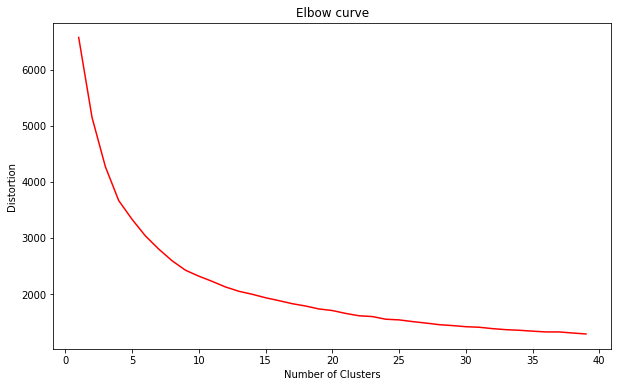

In [61]:
distortion = []
n_clusters = 40

for k in range(1, n_clusters):  
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(pd_playlists_numeric_scaled)
    distortion.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, n_clusters), distortion, c = 'red')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow curve')
plt.show()

**Nhận xét**: theo nguyên tắc Elbow (khuỷu tay) trong phân cụm, ta thấy số cụm tốt nhất ứng với dữ liệu nằm trong khoảng 6-8. Ở đây nhóm em chọn số cụm là 7.

#### tạo k-means model với số cụm tốt nhất (k=7)

In [62]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(pd_playlists_numeric_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [63]:
label = kmeans.labels_
pd_full_tests_copy['cluster_label'] = label

In [64]:
pd_full_tests_copy.head()

,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity,count_available_markets,cluster_label
0,214706,0.392,0.574,7,-9.195,1,0.1700,0.8330,0.001790,0.1450,0.529,81.112,4,91,91,0
1,158032,0.613,0.631,4,-6.965,1,0.1200,0.0663,0.000000,0.1690,0.330,149.992,4,87,92,2
2,216560,0.390,0.724,6,-7.607,0,0.0889,0.1620,0.000000,0.3930,0.312,165.945,4,81,92,6
3,141123,0.607,0.606,0,-5.441,0,0.6810,0.2130,0.000000,0.0853,0.292,79.881,4,65,92,6
4,195586,0.646,0.598,3,-10.293,1,0.0425,0.7300,0.000006,0.1180,0.606,80.993,4,72,92,0


In [65]:
def generate_songs_kmeans(playlist, df_scaled_features, info_df, n_pred, num_clusters = 7, random_state = 2711):
    pid = list(info_df[info_df['track_id'].isin(playlist)]['playlist_id'].value_counts().index)[0]
    df_k = pd.DataFrame(df_scaled_features.copy())

    kmeans = KMeans(n_clusters = num_clusters, random_state = random_state)
    kmeans.fit(df_k)
    
    label = kmeans.labels_
    df_k['cluster_label'] = label
    
    mode_cluster = list(df_k[info_df['playlist_id'] == pid]['cluster_label'].value_counts().index)[0]
    
    our_df = info_df[~(info_df['track_id'].isin(playlist)) & (df_k['cluster_label'] == mode_cluster)]
    our_df = our_df.sort_values(by = 'popularity', ascending=False)

    recs_names = list(np.unique(our_df['track_name'].values))
    preds = collections.Counter(recs_names).most_common(n_pred)
    pred_titles = [p[0] for p in preds]
    return pred_titles

### testing

**Bây giờ ta sẽ thử test phương pháp này trên playlist đầu tiên của tập test**

In [66]:
playlists_to_test = all_playlistID_for_tests[0]

In [67]:
all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[playlists_to_test])]['track_name'].values)
given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[playlists_to_test])]['track_name'].values)

In [68]:
track_name_result = generate_songs_kmeans(track_id_test[playlists_to_test], pd_playlists_numeric_scaled, pd_full_tests, len(track_id_all[playlists_to_test])-len(track_id_test[playlists_to_test]))

In [69]:
print('Songs given: ', given_songs_name, '\n')
print('Songs recommended: ', track_name_result, '\n')

Songs given:  ['Greenland', 'Sunyata', 'Poa Alpina', 'Leaving the Tetons', 'Awash', 'Anything You Synthesize - Ambient', 'Hundrede Træer', 'A Spark, A Beginning', 'Blank Pages', 'Mývatna', 'A Brief Walk in the Sea', 'Natural Cause', 'Antiphon', 'Nothing It Can', 'Anything You Synthesize - Ambient', 'Greenland', 'Nevergreen', 'Small Memory', 'Small Memory', 'Anything You Synthesize - Ambient', 'Small Memory', 'Anything You Synthesize - Ambient', 'Anything You Synthesize - Ambient', 'Small Memory', 'Darashinai Beach', 'Suhpratti', 'Levitate', 'Poa Alpina', 'Leaving the Tetons', 'Awash', 'Greenland', 'Nevergreen', 'W.E.', 'Resonatic', 'Focus', 'Intermission', 'Frigate birds', 'Quietud', 'Hundrede Træer', 'A Spark, A Beginning', 'Blank Pages', 'Mývatna', 'A Brief Walk in the Sea', 'Natural Cause', 'Antiphon', 'Nothing It Can', 'The Five Times I Loved You', 'You Want Dark Tunes?', 'If You Believe', 'Sunyata', 'Father Time', 'Birthmark', 'R.E.M', 'Moving', 'Umbrian Affair', 'Darashinai Beach

**Bây giờ ta sẽ sử dụng tất cả 100 playlists trong bộ test để đánh giá**

In [70]:
def test_multi_feats(pd_playlists, pd_full, fraction = 5, nums_playlists_test = 100):
  r_score = []

  track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
  track_id_test = generate_testcases(track_id_all, fraction = fraction)

  all_playlistID_for_tests = list(track_id_test.keys())

  pd_full_tests = pd_full.copy()
  pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
  pd_full_tests = pd_full_tests.reset_index(drop = True)

  pd_full_tests_copy = pd_full_tests.copy()
  omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'description', 'num_followers', 'available_markets', 'num_tracks']
  pd_full_tests_copy = pd_full_tests_copy.drop(omit_feats, 1)

  # Standardizing the data
  scaler = MinMaxScaler()
  scaler.fit(pd_full_tests_copy)
  pd_playlists_numeric_scaled = scaler.transform(pd_full_tests_copy)

  for each_playlist in all_playlistID_for_tests:
    track_name_result = generate_songs_kmeans(track_id_test[each_playlist], pd_playlists_numeric_scaled, pd_full_tests, len(track_id_all[each_playlist])-len(track_id_test[each_playlist]))

    all_name_songs = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_all[each_playlist])]['track_name'].values)
    given_songs_name = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_test[each_playlist])]['track_name'].values) 
    test_songs_name = [x for x in all_name_songs if x not in given_songs_name]

    r_score.append(r_precision(track_name_result, test_songs_name))

  return r_score

In [71]:
r_score = test_multi_feats(pd_playlists, pd_full, fraction = 5, nums_playlists_test = 100)

print("Average R precision: " + str(np.mean(r_score)))
print("Max R precision: " + str(np.max(r_score)))

Average R precision: 0.041475928643490256
Max R precision: 0.3125


**Test model trên những fraction khác nhau**:

Fraction là tỷ lệ bài hát hiện có trong mỗi playlist, ta dựa vào chúng để đề xuất các bài hát còn lại, ví dụ playlist có 100 bài hát, ta dùng 1/5 số đó (20 bài hát) để dựa vào đó đề xuất 80 bài hát còn lại.

Fraction có giá trị càng bé hoặc càng lớn thì tỷ lệ đề xuất trúng càng thấp.

Ở đây ta test model với các fraction lần lượt là 2 - 10, tức là trong một playlist có 100 bài hát thì ta sẽ dùng 50, 100/3, 25, ..., 10 bài hát đầu tiên để đề xuất số bài hát còn lại.

In [72]:
fraction_to_test = list(np.arange(2, 11))

result_mean = {}
result_max = {}

for fraction in fraction_to_test:
  r_score = test_multi_feats(pd_playlists, pd_full, fraction = fraction, nums_playlists_test = 100)
  result_mean[fraction] = np.mean(r_score)
  result_max[fraction] = np.max(r_score)
  print('-'*30)
  print(f'fraction {fraction}:')
  print("Average R precision: " + str(np.mean(r_score)))
  print("Max R precision: " + str(np.max(r_score))) 
  print('-'*30)

------------------------------
fraction 2:
Average R precision: 0.026909532234365076
Max R precision: 0.36
------------------------------
------------------------------
fraction 3:
Average R precision: 0.02711926400819163
Max R precision: 0.10606060606060606
------------------------------
------------------------------
fraction 4:
Average R precision: 0.050361695644549995
Max R precision: 0.9594594594594594
------------------------------
------------------------------
fraction 5:
Average R precision: 0.04196350303384848
Max R precision: 0.22916666666666666
------------------------------
------------------------------
fraction 6:
Average R precision: 0.04583968092781896
Max R precision: 0.40963855421686746
------------------------------
------------------------------
fraction 7:
Average R precision: 0.03739413378608033
Max R precision: 0.22093023255813954
------------------------------
------------------------------
fraction 8:
Average R precision: 0.059809294063068834
Max R precision: 

In [73]:
print(f'Mean Average R precision over all fractions: {np.mean(list(result_mean.values()))}')
print(f'Mean Max R precision over all fractions: {np.mean(list(result_max.values()))}')

Mean Average R precision over all fractions: 0.04450956755785582
Mean Max R precision over all fractions: 0.41281348721168576


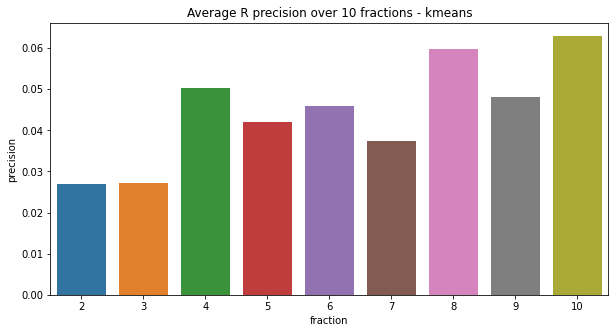

In [75]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(result_mean.keys()), y=list(result_mean.values()))

_ = ax.set_title('Average R precision over 10 fractions - kmeans')

ax.set_ylabel('precision')
ax.set_xlabel('fraction')

plt.savefig('../../images/kmeans_average_R_precision.png', bbox_inches = 'tight')

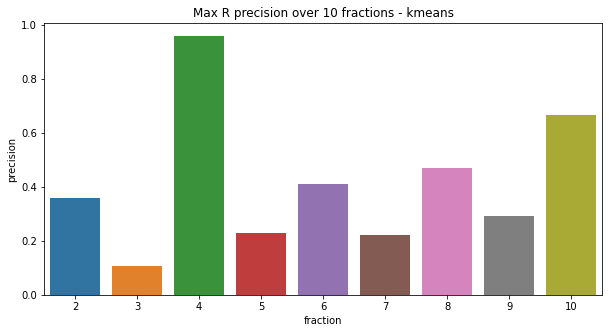

In [76]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(result_max.keys()), y=list(result_max.values()))

_ = ax.set_title('Max R precision over 10 fractions - kmeans')

ax.set_ylabel('precision')
ax.set_xlabel('fraction')

plt.savefig('../../images/kmeans_max_R_precision.png', bbox_inches = 'tight')

In [85]:
result = []

for keys in result_mean:
  result.append({'mean' : result_mean[keys]})

i = 0
for keys in result_max:
  result[i]['max'] = result_max[keys]
  result[i]['fraction'] = i + 2
  i = i + 1

result

[{'fraction': 2, 'max': 0.36, 'mean': 0.026909532234365076},
 {'fraction': 3, 'max': 0.10606060606060606, 'mean': 0.02711926400819163},
 {'fraction': 4, 'max': 0.9594594594594594, 'mean': 0.050361695644549995},
 {'fraction': 5, 'max': 0.22916666666666666, 'mean': 0.04196350303384848},
 {'fraction': 6, 'max': 0.40963855421686746, 'mean': 0.04583968092781896},
 {'fraction': 7, 'max': 0.22093023255813954, 'mean': 0.03739413378608033},
 {'fraction': 8, 'max': 0.47126436781609193, 'mean': 0.059809294063068834},
 {'fraction': 9, 'max': 0.29213483146067415, 'mean': 0.04822344837256032},
 {'fraction': 10, 'max': 0.6666666666666666, 'mean': 0.06296555595021877}]

In [86]:
df_result = pd.DataFrame(result)
df_result.to_csv('kmeans_result.csv', index = False)

**Nhận xét**: 

- Kết quả **Average R precision** của model K-means cũng khá tốt (tốt thứ hai trong 5 loại models mà nhóm đã thí nghiệm), điểm precision dao động từ 0.03 - 0.06 với giá trị fraction tăng từ 2 - 10. 

- Tuy nhiên model có phần không ổn định lắm, giá trị chính xác lớn nhất mà model đề xuất được có khi lên tới gần 1.0 (gần đúng cả playlist) có khi lại chỉ đúng 1-2 bài.